In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import xgboost as xgb


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.ticker as mtick
import seaborn as sns

/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df = df[
        (df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (
                    df['gameType'] == 'R') & (
                    df['periodType'] != 'SHOOTOUT')]

df_dropped = df[df['season']!=20192020]

In [30]:
df_filtered = df_dropped[['isGoal', 'distanceToGoal', 'angleWithGoal']]
df_filtered.head(1)

,isGoal,distanceToGoal,angleWithGoal
0,0.0,34.525353,10.00798


In [34]:
arg_non_goal = df_filtered[df_filtered["isGoal"] == 0].index
arg_to_delete = np.random.choice(arg_non_goal, size=len(df_filtered[df_filtered["isGoal"] == 0]) - len(df_filtered[df_filtered["isGoal"] == 1]), replace=False)

In [35]:
df_filtered = df_filtered.drop(labels=arg_to_delete, axis=0)

In [5]:
df_dropped.columns

Index(['gameId', 'season', 'gameType', 'dateTime', 'team', 'eventIdx', 'event',
       'isGoal', 'shotType', 'description', 'period', 'periodType',
       'periodTime', 'secondsSinceStart', 'strength', 'emptyNet', 'x', 'y',
       'rinkSide', 'distanceToGoal', 'angleWithGoal', 'goalie', 'shooter',
       'assist', 'scorer', 'prevSecondsSinceStart', 'prevEvent', 'prevX',
       'prevY', 'prevAngleWithGoal', 'secondsSincePrev', 'distanceFromPrev',
       'rebound', 'changeOfAngleFromPrev', 'speed', 'speedOfChangeOfAngle'],
      dtype='object')

XGBOOST BASELINE 

In [36]:
train, test = train_test_split(df_filtered, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

x = train[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y = train['isGoal'].to_numpy()

x_test = test[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y_test = test['isGoal'].to_numpy()

(37904, 3)
(18670, 3)


In [46]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x, y)
y_pred = xgb_classifier.predict(x_test)
score_prob = xgb_classifier.predict_proba(x_test)[:, 1]

[23:54:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.3164847 , 0.06594086, 0.45153207, ..., 0.46877328, 0.59314626,
       0.39638573], dtype=float32)

In [38]:
accuracy_score(y_test, y_pred)

0.6568291376539903

0.6563739535847716


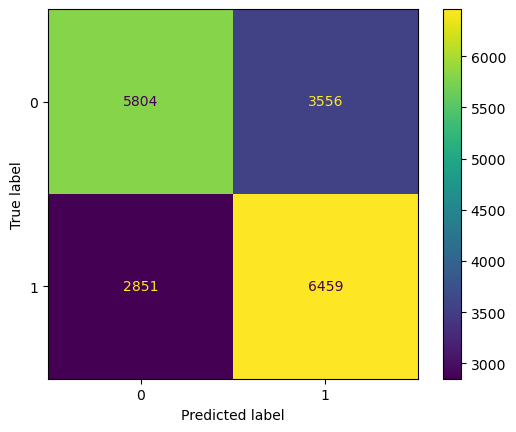

In [53]:
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)
print(f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

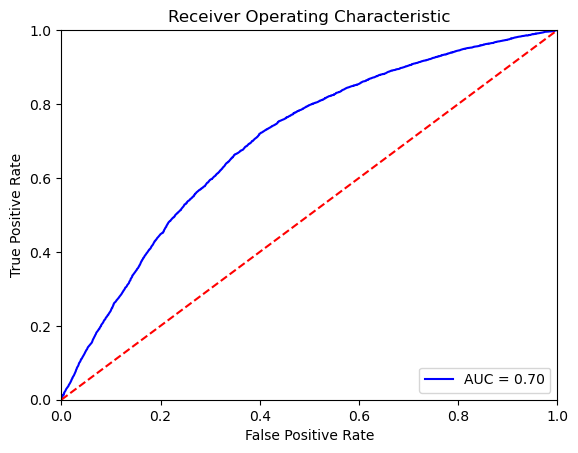

In [54]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
def prepare_goal_rate(y_array, score_prob):
    built_array = []
    index_array = list(range(0, 100, 5))
    total_goal = 0
    goal_array = []
    for i in range(0, 100, 5) :
        sub_y_array = y_array[np.logical_and(score_prob >= np.percentile(score_prob, i), score_prob < np.percentile(score_prob, i+5))]
        goals = np.count_nonzero(sub_y_array)
        shots = sub_y_array.size - goals
        sub_final = goals / (shots + goals)
        goal_array.append(goals)
        total_goal = total_goal + goals
        built_array.append(sub_final*100)
    return built_array, index_array, goal_array, total_goal

In [65]:
def create_goal_rate_plot(index_array, built_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, built_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['XGboost baseline'])
    plt.title("Goal Rate")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Goals / (Shots + Goals)', fontsize=12)
    plt.show()

In [57]:
def compute_cumulative(goal_array, total_goal):
    cumulative_array = []
    last_elem = 0
    for i in np.flip(goal_array):
        if total_goal != 0:
            current = i / total_goal*100 + last_elem
        else:
            current = last_elem
        cumulative_array.append(current)
        
        last_elem = current
    return cumulative_array

In [63]:
def create_cumulative_plot(index_array, cumulative_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, cumulative_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['XGboost baseline'])
    plt.title("Cumulative % of goal")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.show()

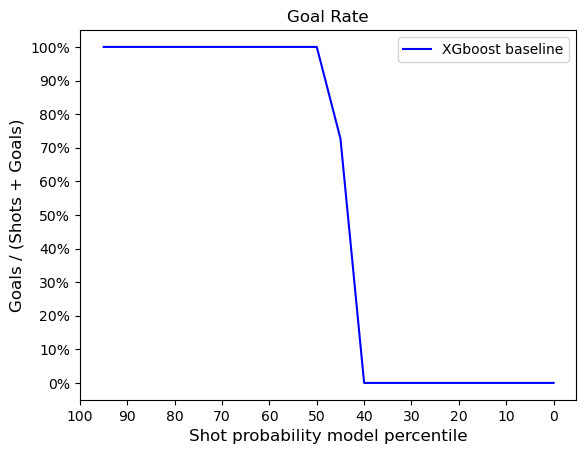

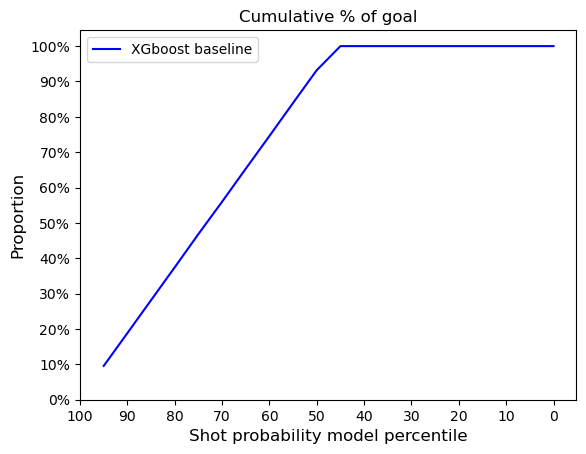

In [66]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_pred, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

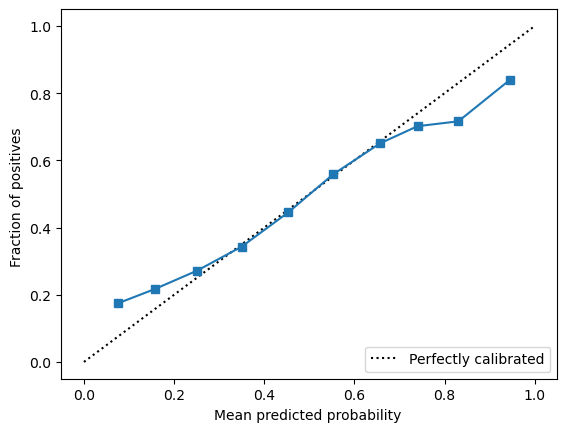

In [67]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

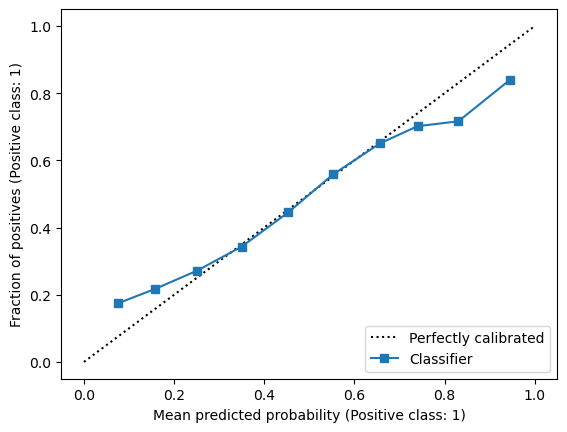

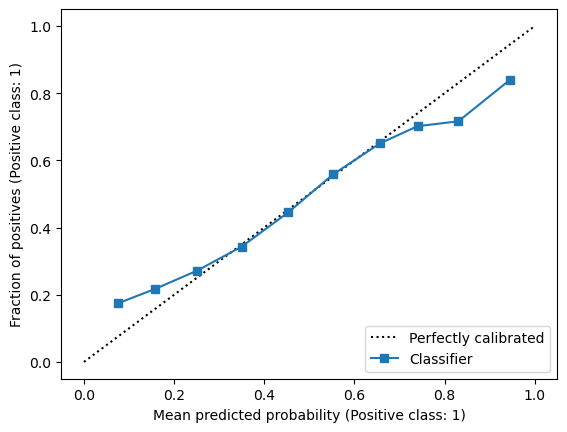

In [68]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob, n_bins = 10).plot()
plt.show()

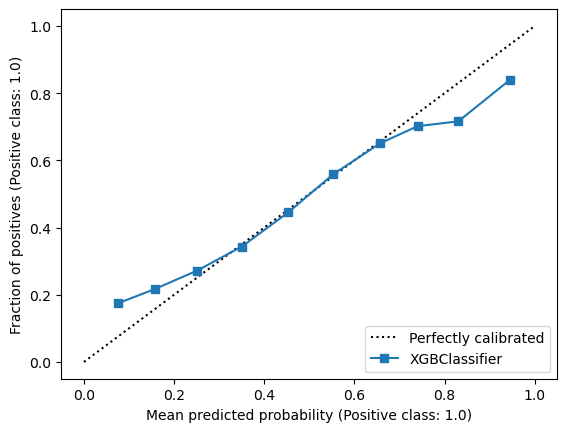

In [70]:
disp = CalibrationDisplay.from_estimator(xgb_classifier, x_test, y_test, n_bins = 10)
plt.show()

XGBOOST USING MORE FEATURES

In [2]:
df = pd.read_csv('ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df = df[
        (df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (
                    df['gameType'] == 'R') & (
                    df['periodType'] != 'SHOOTOUT')]

df_dropped = df[df['season']!=20192020]

In [3]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308709 entries, 0 to 327260
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   gameId                 308709 non-null  int64  
 1   season                 308709 non-null  int64  
 2   gameType               308709 non-null  object 
 3   dateTime               308709 non-null  object 
 4   team                   308709 non-null  object 
 5   eventIdx               308709 non-null  int64  
 6   event                  308709 non-null  object 
 7   isGoal                 308709 non-null  float64
 8   shotType               308679 non-null  object 
 9   description            308709 non-null  object 
 10  period                 308709 non-null  int64  
 11  periodType             308709 non-null  object 
 12  periodTime             308709 non-null  object 
 13  secondsSinceStart      308709 non-null  int64  
 14  strength               28287 non-nul

In [4]:
df_dropped
df_features = df_dropped[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound', 'distanceFromPrev'
                          , 'secondsSincePrev', 'prevAngleWithGoal', 'prevY', 'prevX', 'prevEvent', 'prevSecondsSinceStart',
                          'angleWithGoal', 'distanceToGoal', 'x', 'y', 'emptyNet', 'strength', 'secondsSinceStart', 'shotType']] 
df_label = df_dropped[['isGoal']]
df_dropped.columns

Index(['gameId', 'season', 'gameType', 'dateTime', 'team', 'eventIdx', 'event',
       'isGoal', 'shotType', 'description', 'period', 'periodType',
       'periodTime', 'secondsSinceStart', 'strength', 'emptyNet', 'x', 'y',
       'rinkSide', 'distanceToGoal', 'angleWithGoal', 'goalie', 'shooter',
       'assist', 'scorer', 'prevSecondsSinceStart', 'prevEvent', 'prevX',
       'prevY', 'prevAngleWithGoal', 'secondsSincePrev', 'distanceFromPrev',
       'rebound', 'changeOfAngleFromPrev', 'speed', 'speedOfChangeOfAngle'],
      dtype='object')

In [5]:
df_label.head(1)

,isGoal
0,0.0


In [6]:
df_features.head(1)

,speedOfChangeOfAngle,speed,changeOfAngleFromPrev,rebound,distanceFromPrev,secondsSincePrev,prevAngleWithGoal,prevY,prevX,prevEvent,prevSecondsSinceStart,angleWithGoal,distanceToGoal,x,y,emptyNet,strength,secondsSinceStart,shotType
0,0.0,14.025066,0.0,False,154.275727,11.0,98.365886,-34.0,94.0,Hit,40.0,10.00798,34.525353,-55.0,6.0,NaN,NaN,51,Wrist Shot


In [7]:
df_features.shape

(308709, 19)

In [8]:
df_label.shape

(308709, 1)

In [9]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308709 entries, 0 to 327260
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   speedOfChangeOfAngle   308709 non-null  float64
 1   speed                  308708 non-null  float64
 2   changeOfAngleFromPrev  308709 non-null  float64
 3   rebound                308709 non-null  bool   
 4   distanceFromPrev       308708 non-null  float64
 5   secondsSincePrev       308708 non-null  float64
 6   prevAngleWithGoal      308708 non-null  float64
 7   prevY                  308708 non-null  float64
 8   prevX                  308708 non-null  float64
 9   prevEvent              308708 non-null  object 
 10  prevSecondsSinceStart  308708 non-null  float64
 11  angleWithGoal          308709 non-null  float64
 12  distanceToGoal         308709 non-null  float64
 13  x                      308709 non-null  float64
 14  y                      308709 non-nu

In [10]:
print(df_features['strength'].unique())
print(df_features['shotType'].unique())
print(df_features['prevEvent'].unique())

[nan 'Even' 'Power Play' 'Short Handed']
['Wrist Shot' 'Snap Shot' 'Tip-In' 'Backhand' 'Slap Shot' 'Deflected'
 'Wrap-around' nan]
['Hit' 'Giveaway' 'Shot' 'Faceoff' 'Takeaway' 'Missed Shot' 'Penalty'
 'Blocked Shot' 'Goal' nan]


In [11]:
dummy_object = pd.get_dummies(df_features[['strength', 'shotType', 'prevEvent']])

In [12]:
df_features = df_features.merge(dummy_object, left_index=True, right_index=True)
df_features.head(1)

,speedOfChangeOfAngle,speed,changeOfAngleFromPrev,rebound,distanceFromPrev,secondsSincePrev,prevAngleWithGoal,prevY,prevX,prevEvent,...,shotType_Wrist Shot,prevEvent_Blocked Shot,prevEvent_Faceoff,prevEvent_Giveaway,prevEvent_Goal,prevEvent_Hit,prevEvent_Missed Shot,prevEvent_Penalty,prevEvent_Shot,prevEvent_Takeaway
0,0.0,14.025066,0.0,False,154.275727,11.0,98.365886,-34.0,94.0,Hit,...,1,0,0,0,0,1,0,0,0,0


In [13]:
df_features.shape

(308709, 38)

In [14]:
df_features = df_features.drop(labels = ['strength', 'shotType', 'prevEvent'], axis = 1)

In [15]:
df_features.shape

(308709, 35)

In [16]:
df_label.shape

(308709, 1)

In [17]:
X = df_features
y = df_label

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
params = {
 'learning_rate' : [0.05,0.10],
 'max_depth' : [ 3, 4, 5],
 'min_child_weight' : [ 1, 3],
 'gamma': [ 0.0, 0.1, 0.2],
 'colsample_bytree' : [ 0.3, 0.4, 0.5], 
    'n_estimators': [300,400,500], 
    'booster':['gbtree','gblinear']
}

In [20]:
xgb_classifier = xgb.XGBClassifier()
xgb = RandomizedSearchCV(xgb_classifier, param_distributions = params, n_iter=5,scoring='roc_auc', cv =5)
xgb.fit(X_train, y_train, eval_metric='rmse')
y_pred = xgb.predict(X_test)
score_prob = xgb.predict_proba(X_test)[:, 1]

/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was 

[02:07:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:08:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:08:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:08:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:08:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:08:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:08:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:09:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:09:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:09:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:13:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:14:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:14:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:14:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:14:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 

[02:15:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [28]:
pd.DataFrame(xgb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,param_booster,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.533526,0.490353,0.323846,0.009740,400,1,3,0.05,0.1,0.4,gblinear,"{'n_estimators': 400, 'min_child_weight': 1, '...",1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00,1
1,10.173861,0.711298,0.318061,0.010067,400,3,5,0.05,0.0,0.3,gblinear,"{'n_estimators': 400, 'min_child_weight': 3, '...",1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00,1
2,31.045194,2.007650,0.339186,0.042344,400,1,4,0.05,0.1,0.4,gbtree,"{'n_estimators': 400, 'min_child_weight': 1, '...",1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00,1
3,20.156080,0.566168,0.309864,0.009084,400,3,4,0.1,0.2,0.3,gbtree,"{'n_estimators': 400, 'min_child_weight': 3, '...",1.0,1.0,1.0,1.0,1.0,1.0,4.965068e-17,1
4,12.634754,0.727587,0.319078,0.011299,500,1,5,0.1,0.0,0.5,gblinear,"{'n_estimators': 500, 'min_child_weight': 1, '...",1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00,1


In [26]:
xgb.best_params_

{'n_estimators': 400,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.4,
 'booster': 'gblinear'}

In [27]:
xgb.best_score_

1.0

In [21]:
accuracy_score(y_test, y_pred)

1.0

1.0


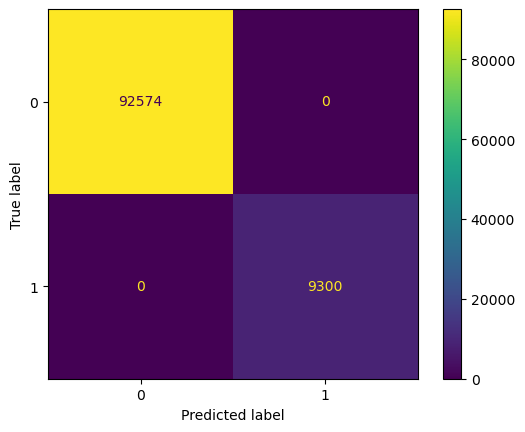

In [22]:
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)
print(f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

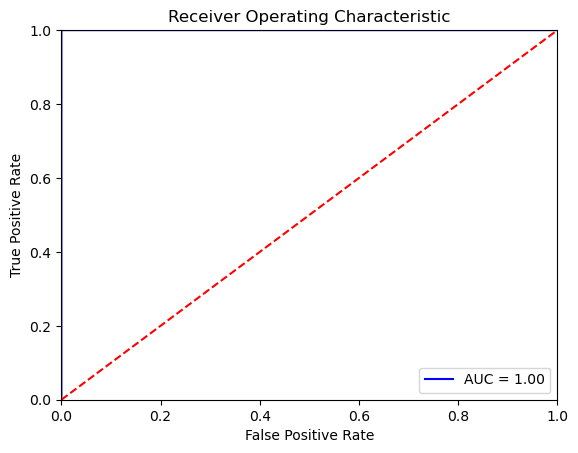

In [23]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()